#### Note - adapted from hls4ml tutorial part 4
#### https://github.com/fastmachinelearning/hls4ml-tutorial/

In [1]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf

tf.random.set_seed(seed)
import os

os.environ['XILINX_VIVADO'] = '/vol/cc/opt/Xilinx/2020.1/Vivado/2020.1'
os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']

2025-06-04 15:17:00.413555: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## OpenML jet tagging dataset

In [2]:
fetch_data = False

In [3]:
if fetch_data:
    data = fetch_openml('hls4ml_lhc_jets_hlf')
    X, y = data['data'], data['target']

    # One-hot encode and split into training and validation sets
    le = LabelEncoder()
    y = le.fit_transform(y)
    y = to_categorical(y, 5)
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_val = scaler.fit_transform(X_train_val)
    X_test = scaler.transform(X_test)

    np.save('X_train_val.npy', X_train_val)
    np.save('X_test.npy', X_test)
    np.save('y_train_val.npy', y_train_val)
    np.save('y_test.npy', y_test)
    np.save('classes.npy', le.classes_)

In [4]:
X_train_val = np.load('X_train_val.npy')
X_test = np.load('X_test.npy')
y_train_val = np.load('y_train_val.npy')
y_test = np.load('y_test.npy')
classes = np.load('classes.npy', allow_pickle=True)

## Model instantiation

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from callbacks_pre import all_callbacks
from tensorflow.keras.layers import Activation
from qkeras.qlayers import QDense, QActivation
from qkeras.quantizers import quantized_bits, quantized_relu

In [6]:
model = Sequential()
model.add(
    QDense(
        64,
        input_shape=(16,),
        name='fc1',
        kernel_quantizer=quantized_bits(6, 0, alpha=1),
        bias_quantizer=quantized_bits(6, 0, alpha=1),
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
    )
)
model.add(QActivation(activation=quantized_relu(6), name='relu1'))
model.add(
    QDense(
        32,
        name='fc2',
        kernel_quantizer=quantized_bits(6, 0, alpha=1),
        bias_quantizer=quantized_bits(6, 0, alpha=1),
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
    )
)
model.add(QActivation(activation=quantized_relu(6), name='relu2'))
model.add(
    QDense(
        32,
        name='fc3',
        kernel_quantizer=quantized_bits(6, 0, alpha=1),
        bias_quantizer=quantized_bits(6, 0, alpha=1),
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
    )
)
model.add(QActivation(activation=quantized_relu(6), name='relu3'))
model.add(
    QDense(
        5,
        name='output',
        kernel_quantizer=quantized_bits(6, 0, alpha=1),
        bias_quantizer=quantized_bits(6, 0, alpha=1),
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
    )
)
model.add(Activation(activation='softmax', name='softmax'))

## Model training

In [7]:
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning

# QKeras layers are prunable
pruning_params = {"pruning_schedule": pruning_schedule.ConstantSparsity(0.75, begin_step=2000, frequency=100)}
model = prune.prune_low_magnitude(model, **pruning_params)

## Train the model
We'll use the same settings as the model for part 1: Adam optimizer with categorical crossentropy loss.
The callbacks will decay the learning rate and save the model into a directory 'model_2'
The model isn't very complex, so this should just take a few minutes even on the CPU.
If you've restarted the notebook kernel after training once, set `train = False` to load the trained model rather than training again.

In [8]:
train = False
if train:
    adam = Adam(lr=0.0001)
    model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    callbacks = all_callbacks(
        stop_patience=1000,
        lr_factor=0.5,
        lr_patience=10,
        lr_epsilon=0.000001,
        lr_cooldown=2,
        lr_minimum=0.0000001,
        outputDir='quantised_pruned_jet_tagging_model',
    )
    callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep())
    model.fit(
        X_train_val,
        y_train_val,
        batch_size=1024,
        epochs=30,
        validation_split=0.25,
        shuffle=True,
        callbacks=callbacks.callbacks,
    )
    # Save the model again but with the pruning 'stripped' to use the regular layer types
    model = strip_pruning(model)
    model.save('quantised_pruned_jet_tagging_model/KERAS_check_best_model.h5')
else:
    from tensorflow.keras.models import load_model
    from qkeras.utils import _add_supported_quantized_objects

    co = {}
    _add_supported_quantized_objects(co)
    model = load_model('quantised_pruned_jet_tagging_model/KERAS_check_best_model.h5', custom_objects=co)

Epoch 1/30


/mnt/ccnas2/tdp/tr720/final-year-project-workspace/miniconda/envs/heterogeneous-hls4ml-env/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


  1/487 [..............................] - ETA: 27:15 - loss: 1.7370 - accuracy: 0.1025WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0055s vs `on_train_batch_end` time: 0.0105s). Check your callbacks.


485/487 [============================>.] - ETA: 0s - loss: 0.9770 - accuracy: 0.6754
***callbacks***
saving losses to quantised_pruned_jet_tagging_model/losses.log

Epoch 1: val_loss improved from inf to 0.81069, saving model to quantised_pruned_jet_tagging_model/KERAS_check_best_model.h5

Epoch 1: val_loss improved from inf to 0.81069, saving model to quantised_pruned_jet_tagging_model/KERAS_check_best_model_weights.h5

Epoch 1: saving model to quantised_pruned_jet_tagging_model/KERAS_check_model_last.h5

Epoch 1: saving model to quantised_pruned_jet_tagging_model/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 7s 7ms/step - loss: 0.9765 - accuracy: 0.6756 - val_loss: 0.8107 - val_accuracy: 0.7364 - lr: 0.0010
Epoch 2/30
 12/487 [..............................] - ETA: 2s - loss: 0.8026 - accuracy: 0.7404

/mnt/ccnas2/tdp/tr720/final-year-project-workspace/miniconda/envs/heterogeneous-hls4ml-env/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


487/487 [==============================] - ETA: 0s - loss: 0.7803 - accuracy: 0.7455
***callbacks***
saving losses to quantised_pruned_jet_tagging_model/losses.log

Epoch 2: val_loss improved from 0.81069 to 0.76623, saving model to quantised_pruned_jet_tagging_model/KERAS_check_best_model.h5

Epoch 2: val_loss improved from 0.81069 to 0.76623, saving model to quantised_pruned_jet_tagging_model/KERAS_check_best_model_weights.h5

Epoch 2: saving model to quantised_pruned_jet_tagging_model/KERAS_check_model_last.h5

Epoch 2: saving model to quantised_pruned_jet_tagging_model/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 3s 5ms/step - loss: 0.7803 - accuracy: 0.7455 - val_loss: 0.7662 - val_accuracy: 0.7494 - lr: 0.0010
Epoch 3/30
487/487 [==============================] - ETA: 0s - loss: 0.7545 - accuracy: 0.7519
***callbacks***
saving losses to quantised_pruned_jet_tagging_model/losses.log

Epoch 3: val_loss improved from 0.76623 to 0

## Check performance
How does this model which was trained using 6-bits, and 75% sparsity model compare against the original model? Let's report the accuracy and make a ROC curve. The quantized, pruned model is shown with solid lines, the unpruned model from part 1 is shown with dashed lines.


We should also check that hls4ml can respect the choice to use 6-bits throughout the model, and match the accuracy. We'll generate a configuration from this Quantized model, and plot its performance as the dotted line.
The generated configuration is printed out. You'll notice that it uses 7 bits for the type, but we specified 6!? That's just because QKeras doesn't count the sign-bit when we specify the number of bits, so the type that actually gets used needs 1 more.

We also use the `OutputRoundingSaturationMode` optimizer pass of `hls4ml` to set the Activation layers to round, rather than truncate, the cast. This is important for getting good model accuracy when using small bit precision activations. And we'll set a different data type for the tables used in the Softmax, just for a bit of extra performance.


**Make sure you've trained the model from part 1**

In [9]:
import hls4ml
import plotting_pre

config = hls4ml.utils.config_from_keras_model(model, granularity='name', backend='Vivado')
config['LayerName']['softmax']['exp_table_t'] = 'ap_fixed<18,8>'
config['LayerName']['softmax']['inv_table_t'] = 'ap_fixed<18,4>'
print("-----------------------------------")
plotting_pre.print_dict(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, backend='Vivado', output_dir='quantised_pruned_jet_tagging_model/hls4ml_prj', part='xc7z020clg400-1'
)
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)
# hls_model.compile()

# y_qkeras = model.predict(np.ascontiguousarray(X_test))
# y_hls = hls_model.predict(np.ascontiguousarray(X_test))
# np.save('quantised_pruned_jet_tagging_model/y_qkeras.npy', y_qkeras)
# np.save('quantised_pruned_jet_tagging_model/y_hls.npy', y_hls)

/mnt/ccnas2/tdp/tr720/final-year-project-workspace/miniconda/envs/heterogeneous-hls4ml-env/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: QDense, input shapes: [[None, 16]], output shape: [None, 64]
Layer name: relu1, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: fc2, layer type: QDense, input shapes: [[None, 64]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: QDense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: QDense, input shapes: [[None, 32]], output shape: [None, 5]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 5]], output shape: [None, 5]
-----------------------------------
Model
  Precision
    default:         fixed<16,6>
  ReuseFactor:       1
  Strategy:  

In [ ]:
plotting_pre.print_dict(hls_model.get_dict())

5188/5188 [==============================] - 6s 1ms/step
Accuracy baseline:  0.7640722891566265
Accuracy pruned, quantized: 0.760933734939759
Accuracy hls4ml: 0.7609397590361445


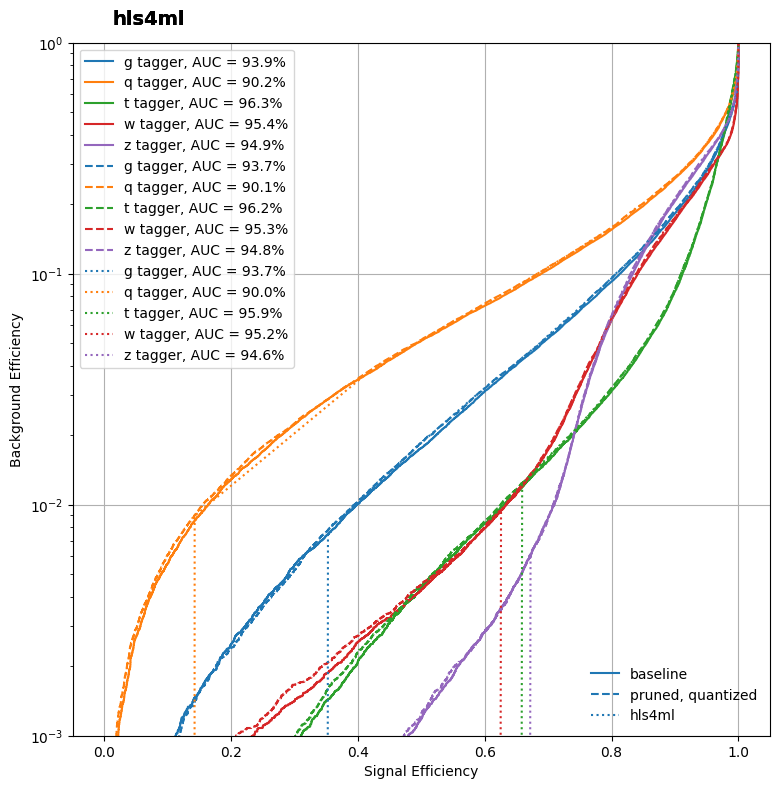

In [10]:
%matplotlib inline
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model

model_ref = load_model('baseline_jet_tagging_model/KERAS_check_best_model.h5')
y_ref = model_ref.predict(X_test)

print("Accuracy baseline:  {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_ref, axis=1))))
print("Accuracy pruned, quantized: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_qkeras, axis=1))))
print("Accuracy hls4ml: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting_pre.makeRoc(y_test, y_ref, classes)
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting_pre.makeRoc(y_test, y_qkeras, classes, linestyle='--')
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting_pre.makeRoc(y_test, y_hls, classes, linestyle=':')

from matplotlib.lines import Line2D

lines = [Line2D([0], [0], ls='-'), Line2D([0], [0], ls='--'), Line2D([0], [0], ls=':')]
from matplotlib.legend import Legend

leg = Legend(ax, lines, labels=['baseline', 'pruned, quantized', 'hls4ml'], loc='lower right', frameon=False)
ax.add_artist(leg)

## Synthesize
Now let's synthesize this quantized, pruned model.

**The synthesis will take a while**

While the C-Synthesis is running, we can monitor the progress looking at the log file by opening a terminal from the notebook home, and executing:

`tail -f model_3/hls4ml_prj/vitis_hls.log`

In [11]:
hls_model.build(synth=True)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2020.1 (64-bit)
  **** SW Build 2902540 on Wed May 27 19:54:35 MDT 2020
  **** IP Build 2902112 on Wed May 27 22:43:36 MDT 2020
    ** Copyright 1986-2020 Xilinx, Inc. All Rights Reserved.

source /vol/cc/opt/Xilinx/2020.1/Vivado/2020.1/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/vol/cc/opt/Xilinx/2020.1/Vivado/2020.1/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'tr720' on host 'cccad4.doc.ic.ac.uk' (Linux_x86_64 version 3.10.0-1160.76.1.el7.x86_64) on Wed Jun 04 15:19:29 BST 2025
INFO: [HLS 200-10] On os "CentOS Linux release 7.9.2009 (Core)"
INFO: [HLS 200-10] In directory '/mnt/ccnas2/tdp/tr720/final-year-project-workspace/heterogeneous-hls4ml-testing/quantised_pruned_jet_tagging_model/hls4ml_prj'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Opening project '/mnt/ccnas2/tdp/tr720/final-year-project-workspace/hetero

{'CSimResults': [['0.0517578', '0.125977', '0.5', '0.208008', '0.142578'],
  ['0.0517578', '0.125977', '0.5', '0.208008', '0.142578'],
  ['0.0517578', '0.125977', '0.5', '0.208008', '0.142578'],
  ['0.0517578', '0.125977', '0.5', '0.208008', '0.142578'],
  ['0.0517578', '0.125977', '0.5', '0.208008', '0.142578']],
 'CSynthesisReport': {'TargetClockPeriod': '5.00',
  'EstimatedClockPeriod': '4.362',
  'BestLatency': '39',
  'WorstLatency': '39',
  'IntervalMin': '1',
  'IntervalMax': '1',
  'BRAM_18K': '4',
  'DSP': '25',
  'FF': '30375',
  'LUT': '42854',
  'URAM': '0',
  'AvailableBRAM_18K': '280',
  'AvailableDSP': '220',
  'AvailableFF': '106400',
  'AvailableLUT': '53200',
  'AvailableURAM': '0'}}

## Check the reports
Print out the reports generated by Vitis HLS. Pay attention to the Utilization Estimates' section in particular this time.

In [12]:
hls4ml.report.read_vivado_report('quantised_pruned_jet_tagging_model/hls4ml_prj')

Found 1 solution(s) in quantised_pruned_jet_tagging_model/hls4ml_prj/myproject_prj.
Reports for solution "solution1":

C SIMULATION RESULT:
INFO: [SIM 2] *************** CSIM start ***************
INFO: [SIM 4] CSIM will launch GCC as the compiler.
   Compiling ../../../../myproject_test.cpp in debug mode
   Compiling ../../../../firmware/myproject.cpp in debug mode
   Generating csim.exe
INFO: Unable to open input/predictions file, using default input.
0.0517578 0.125977 0.5 0.208008 0.142578 
0.0517578 0.125977 0.5 0.208008 0.142578 
0.0517578 0.125977 0.5 0.208008 0.142578 
0.0517578 0.125977 0.5 0.208008 0.142578 
0.0517578 0.125977 0.5 0.208008 0.142578 
INFO: Saved inference results to file: tb_data/csim_results.log
INFO: [SIM 1] CSim done with 0 errors.
INFO: [SIM 3] *************** CSIM finish ***************

SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject'
* Date:           Wed Jun  4 15:25:56 2025

* Version:        2020.1 (Build 2897737 on Wed May 27 20:21:37 MDT 2020

Print the report for the model trained in part 1. Now, compared to the model from part 1, this model has been trained with low-precision quantization, and 75% pruning. You should be able to see that we have saved a lot of resource compared to where we started in part 1. At the same time, referring to the ROC curve above, the model performance is pretty much identical even with this drastic compression!

**Note you need to have trained and synthesized the model from part 1**

In [13]:
hls4ml.report.read_vivado_report('baseline_jet_tagging_model/hls4ml_prj')

Found 1 solution(s) in baseline_jet_tagging_model/hls4ml_prj/myproject_prj.
Reports for solution "solution1":

C SIMULATION RESULT:
INFO: [SIM 2] *************** CSIM start ***************
INFO: [SIM 4] CSIM will launch GCC as the compiler.
   Compiling ../../../../myproject_test.cpp in debug mode
   Compiling ../../../../firmware/myproject.cpp in debug mode
   Generating csim.exe
INFO: Unable to open input/predictions file, using default input.
0.0332031 0.103516 0.282227 0.234375 0.363281 
0.0332031 0.103516 0.282227 0.234375 0.363281 
0.0332031 0.103516 0.282227 0.234375 0.363281 
0.0332031 0.103516 0.282227 0.234375 0.363281 
0.0332031 0.103516 0.282227 0.234375 0.363281 
INFO: Saved inference results to file: tb_data/csim_results.log
INFO: [SIM 1] CSim done with 0 errors.
INFO: [SIM 3] *************** CSIM finish ***************

SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject'
* Date:           Wed Jun  4 14:57:23 2025

* Version:        2020.1 (Build 2897737 on Wed May 27 

Print the report for the model trained in part 3. Both these models were trained with 75% sparsity, but the new model uses 6-bit precision as well. You can see how Vitis HLS has moved multiplication operations from DSPs into LUTs, reducing the "critical" resource usage.

**Note you need to have trained and synthesized the model from part 3**

In [14]:
hls4ml.report.read_vivado_report('pruned_jet_tagging_model/hls4ml_prj')

Found 1 solution(s) in pruned_jet_tagging_model/hls4ml_prj/myproject_prj.
Reports for solution "solution1":

C SIMULATION RESULT:
INFO: [SIM 2] *************** CSIM start ***************
INFO: [SIM 4] CSIM will launch GCC as the compiler.
   Compiling ../../../../myproject_test.cpp in debug mode
   Compiling ../../../../firmware/myproject.cpp in debug mode
   Generating csim.exe
INFO: Unable to open input/predictions file, using default input.
0.0537109 0.15625 0.400391 0.242188 0.176758 
0.0537109 0.15625 0.400391 0.242188 0.176758 
0.0537109 0.15625 0.400391 0.242188 0.176758 
0.0537109 0.15625 0.400391 0.242188 0.176758 
0.0537109 0.15625 0.400391 0.242188 0.176758 
INFO: Saved inference results to file: tb_data/csim_results.log
INFO: [SIM 1] CSim done with 0 errors.
INFO: [SIM 3] *************** CSIM finish ***************

SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject'
* Date:           Wed Jun  4 15:05:52 2025

* Version:        2020.1 (Build 2897737 on Wed May 27 20:21:3

## NB
Note as well that the Vitis HLS resource estimates tend to _overestimate_ LUTs, while generally estimating the DSPs correctly. Running the subsequent stages of FPGA compilation reveals the more realistic resource usage, You can run the next step, 'logic synthesis' with `hls_model.build(synth=True, vsynth=True)`, but we skipped it in this tutorial in the interest of time.

In [15]:
#hls_model.build(synth=True, vsynth=True)